# Loading lib and Establishing connection to DWH

In [165]:
import pandas as pd
import numpy as np
import plotly.express as px
import os 
import json
import sys

from functools import lru_cache

from botocore.exceptions import ClientError

In [166]:
# Tells the location of folders (e.g. aws folder) - creates a path
from user_path import set_up_path 

PATH = set_up_path()
sys.path.append(PATH['tools'])
sys.path.append(PATH['tools'] + '/functions')


In [167]:
# Importing custom libraries to connect to DWS and GSheet
from functions.database import get_data_from_warehouse
from utils.gspread.gsheet_data import GetSheetData

# Quick EDA

In [168]:
# CA and pool onboarded drivers worked in 
query = """

SELECT d.driver_id,
  --     d.applicant_fountain_id,
       uam.application_fountain_id,
       uam.postcode_found as driver_postCode,
       uam.application_pool,
       a.area_name_uscore,
   --    a.area_name_cap,
       a.area_name_clean,
       a.catchment_area,
       min(d.valid_from_date),
       uam.lat as lat_driver, ---- Just in case
       uam.long as long_driver---- Just in case
 --      z.zone_name

FROM modeled_core.driver d

INNER JOIN ops.uk_application_mapping uam
    ON uam.application_fountain_id = d.applicant_fountain_id

LEFT JOIN ops.area a
    ON uam.application_pool = a.area_name_uscore

WHERE d.zone_id = 2
group by 1,2,3,4,5,6,7,9,10

"""
courier_mapping = get_data_from_warehouse(query)

Connected to the DataWarehouse
Result from query obtained
Data stored in dataframe


In [169]:
courier_mapping

,driver_id,application_fountain_id,driver_postcode,application_pool,area_name_uscore,area_name_clean,catchment_area,min,lat_driver,long_driver
0,343571,8c74d554-5abe-4be1-a2dd-c0c7d8033551,SW16 1JJ,Balham,Balham,Balham,London Inner S,2021-01-14,51.434972,-0.130011
1,343678,9d6e1346-60e7-493e-9c45-e6e40fb2d095,N8 9JT,Finsbury_Park,Finsbury_Park,Finsbury Park,London Outer N,2021-01-14,51.582547,-0.116439
2,355171,ae304ea7-491f-4d5d-a2a2-7c2df12f32b5,IG3 8DP,Goodmayes,Goodmayes,Goodmayes,London Border NE,2021-02-02,51.563420,0.102252
3,346970,d82d3ede-c397-4cad-b22a-88c14af819f1,HA0 3DJ,Wembley,Wembley,Wembley,London Outer Upper NW,2021-01-19,51.556704,-0.311459
4,351359,fbb15f06-5ace-4d00-bab8-59feb72846af,N16 5EA,Stoke_Newington,Stoke_Newington,Stoke Newington,London Inner N,2021-01-26,51.572555,-0.083040
...,...,...,...,...,...,...,...,...,...,...
11198,473591,7b878fc0-1f6a-48ae-81e4-b01529a58ca5,E13 8PJ,Canning_Town,Canning_Town,Canning Town,London Outer NE,2021-11-18,51.519696,0.030847
11199,473326,7a82995f-73f4-4c90-8724-4b7fd1a3712a,E7 8JF,East_Ham,East_Ham,East Ham,London Outer NE,2021-11-18,51.544574,0.032185
11200,473754,c71e54d4-4265-4709-b0c0-6c17ec2e8684,HA0 4LL,Wembley,Wembley,Wembley,London Outer Upper NW,2021-11-18,51.541558,-0.298081
11201,507038,90d80a9b-77eb-4532-b8f2-78c8a610ecd5,SE25 5BQ,Croydon_Central,Croydon_Central,Croydon Central,London Outer S,2022-01-20,51.390436,-0.071488


In [170]:
courier_mapping.describe()

,driver_id,lat_driver,long_driver
count,11203.000000,11135.000000,11135.000000
mean,429625.089797,51.539302,-0.175463
std,48685.277243,0.308542,0.434795
min,339072.000000,50.339817,-4.978623
25%,392562.500000,51.450588,-0.255441
50%,424321.000000,51.523355,-0.107344
75%,473557.500000,51.568359,-0.009161
max,510700.000000,56.127844,1.122188


In [171]:
courier_mapping['driver_id'].nunique()

11203

In [172]:
courier_mapping.isnull().sum()

driver_id                     0
application_fountain_id       0
driver_postcode               0
application_pool              0
area_name_uscore           1172
area_name_clean            1172
catchment_area             1172
min                           0
lat_driver                   68
long_driver                  68
dtype: int64

In [173]:
# Percentage of couriers not living in CA in London
not_in_CA = courier_mapping['catchment_area'].isnull().sum() * 100 / len(courier_mapping.catchment_area)
print(not_in_CA)

10.461483531197


In [174]:
# Percentage of couriers living in CA in London
in_CA = courier_mapping['catchment_area'].notnull().sum() * 100 / len(courier_mapping.catchment_area)
print(in_CA)

89.538516468803


In [175]:
courier_inCA = courier_mapping

In [176]:
courier_mapping['in_CA']= np.where(courier_mapping['catchment_area'].notnull() , 'Yes' , 'No')
courier_mapping

,driver_id,application_fountain_id,driver_postcode,application_pool,area_name_uscore,area_name_clean,catchment_area,min,lat_driver,long_driver,in_CA
0,343571,8c74d554-5abe-4be1-a2dd-c0c7d8033551,SW16 1JJ,Balham,Balham,Balham,London Inner S,2021-01-14,51.434972,-0.130011,Yes
1,343678,9d6e1346-60e7-493e-9c45-e6e40fb2d095,N8 9JT,Finsbury_Park,Finsbury_Park,Finsbury Park,London Outer N,2021-01-14,51.582547,-0.116439,Yes
2,355171,ae304ea7-491f-4d5d-a2a2-7c2df12f32b5,IG3 8DP,Goodmayes,Goodmayes,Goodmayes,London Border NE,2021-02-02,51.563420,0.102252,Yes
3,346970,d82d3ede-c397-4cad-b22a-88c14af819f1,HA0 3DJ,Wembley,Wembley,Wembley,London Outer Upper NW,2021-01-19,51.556704,-0.311459,Yes
4,351359,fbb15f06-5ace-4d00-bab8-59feb72846af,N16 5EA,Stoke_Newington,Stoke_Newington,Stoke Newington,London Inner N,2021-01-26,51.572555,-0.083040,Yes
...,...,...,...,...,...,...,...,...,...,...,...
11198,473591,7b878fc0-1f6a-48ae-81e4-b01529a58ca5,E13 8PJ,Canning_Town,Canning_Town,Canning Town,London Outer NE,2021-11-18,51.519696,0.030847,Yes
11199,473326,7a82995f-73f4-4c90-8724-4b7fd1a3712a,E7 8JF,East_Ham,East_Ham,East Ham,London Outer NE,2021-11-18,51.544574,0.032185,Yes
11200,473754,c71e54d4-4265-4709-b0c0-6c17ec2e8684,HA0 4LL,Wembley,Wembley,Wembley,London Outer Upper NW,2021-11-18,51.541558,-0.298081,Yes
11201,507038,90d80a9b-77eb-4532-b8f2-78c8a610ecd5,SE25 5BQ,Croydon_Central,Croydon_Central,Croydon Central,London Outer S,2022-01-20,51.390436,-0.071488,Yes


In [177]:
in_CA = courier_mapping.groupby('in_CA').agg({'driver_id':'count'}).reset_index()
in_CA

,in_CA,driver_id
0,No,1172
1,Yes,10031


In [178]:
# Percentage of drivers who live within CA
in_CA['Percentage_drivers_inCA'] = (in_CA['driver_id']/in_CA['driver_id'].sum()) * 100
in_CA = in_CA.round(0)

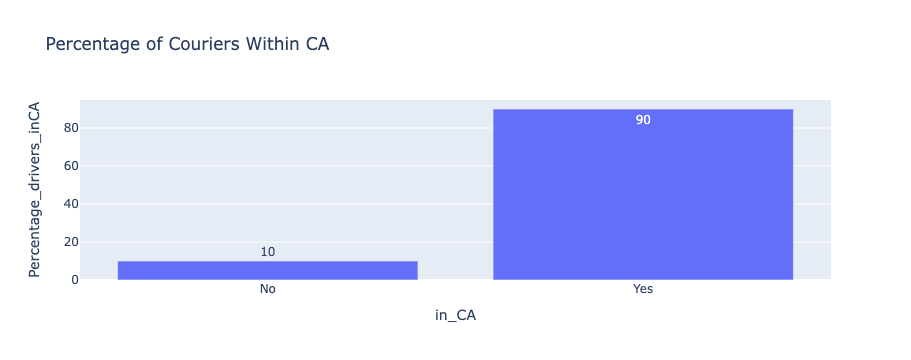

In [179]:
fig1 = px.bar(in_CA, x = 'in_CA' , y = 'Percentage_drivers_inCA', title= 'Percentage of Couriers Within CA', text = 'Percentage_drivers_inCA')
fig1.show()


In [180]:
# Top 5 CA with highest number of resident couriers
top_5_CA = courier_mapping.groupby('catchment_area').agg({'driver_id':'count'}).reset_index()
top_5_CA.head(5)

,catchment_area,driver_id
0,Altrincham,1
1,Basildon,5
2,Bath,1
3,Birmingham Central,4
4,Birmingham East,1


In [181]:
# Sorting values in descending order
top_5_CA = top_5_CA.sort_values(by='driver_id', ascending=False)
top_5_CA.head(5)

,catchment_area,driver_id
39,London Outer NE,1104
38,London Outer N,1009
43,London Outer Upper NW,895
33,London Inner S,853
32,London Inner N,659


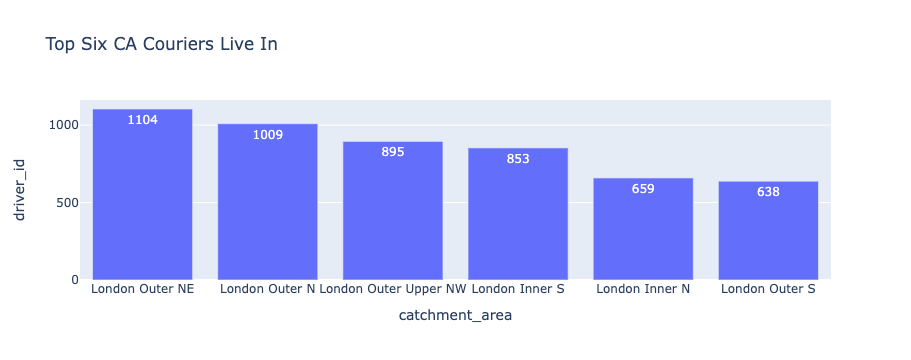

In [182]:
fig2 = px.bar(top_5_CA.head(6), x = 'catchment_area' , y = 'driver_id', title = 'Top Six CA Couriers Live In' , text = 'driver_id')
fig2.show()

# PC Mapping

###  Database used:

modeled_core.driver, 
modeled_core.delivery,
modeled_core.zones,
modeled_core.packages,
modeled_core.location,
ops.area,
ops.uk_application_mapping

In [183]:
query_2 = '''

SELECT -------------------- Package
       cd.driver_id,          -- stuart_driver_id
    MIN(cd.valid_from_date) as earliest_date,
       a.catchment_area as pu_CA,

    ------------------  Driver
       uam.postcode_found as driver_postCode,
       ad.catchment_area as driver_CA,
       count( distinct p.package_id) as no_packages,
       uam.application_fountain_id

FROM modeled_core.driver cd

INNER JOIN modeled_core.zones z
USING (zone_id)

LEFT JOIN modeled_core.delivery d
    ON cd.driver_id = d.driver_id

LEFT JOIN modeled_core.package p
    ON d.package_id = p.package_id

LEFT JOIN modeled_core.location l
    ON p.pu_location_id = l.location_id

LEFT JOIN ops.area a
    ON REPLACE(l.delivery_area_name , '_' , '') = a.area_name_cap -- pool area for packages

LEFT JOIN ops.uk_application_mapping uam
    ON uam.application_fountain_id = cd.applicant_fountain_id

LEFT JOIN ops.area ad
    ON uam.application_pool = ad.area_name_uscore   -- pool area for driver ca

WHERE z.country_id = 2
AND DATE(p.time_window_pu_start_utc) >= '2021-01-01'
AND DATE(cd.onboarded_at_utc) >= '2021-01-01'

GROUP BY 1, 3, 4, 5, 7

'''

deliveries = get_data_from_warehouse(query_2)

Connected to the DataWarehouse
Result from query obtained
Data stored in dataframe


In [184]:
# Getting multiple rows per driver as they can work in different catchment areas
deliveries.shape

(61120, 7)

In [185]:
deliveries.head(5)

,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,no_packages,application_fountain_id
0,462324,2021-10-28,London Outer S,SE16 3XY,London Inner E,4,e3115500-e059-47a6-9480-2d2e1ddd2b4f
1,355681,2021-02-03,Liverpool Wirral,CH44 4DY,Liverpool Wirral,3013,ba42cf8b-90fe-424e-914e-d1398d9655a3
2,365751,2021-02-22,Leeds City,LS9 7QS,Leeds East,1924,d1debddd-61d2-4c2b-987b-9f4864573040
3,405653,2021-05-26,London Outer N,N4 1LF,London Outer N,4059,f5f87ad8-f66c-4e43-b184-32df59cfa71c
4,368723,2021-02-26,London Border W,None,None,4724,None


In [186]:
no_dup_deliveries = deliveries.drop_duplicates()
no_dup_deliveries.shape
# No duplicates

(61120, 7)

In [187]:
no_dup_deliveries['driver_id'].nunique()

24097

In [188]:
# checking how many drivers have application_fountain_id as non-NULL
no_dup_deliveries = no_dup_deliveries[no_dup_deliveries['application_fountain_id'].isnull()==False]
no_dup_deliveries['driver_id'].nunique()


18618

In [189]:
# Generating a csv file with drivers and their deliveries
no_dup_deliveries.to_csv('data/deliveries_and_catchement_areas.csv' , index = False )

In [190]:
# Dropped all None values in driver_ca: Removing drivers who don't live in CA
no_dup_deliveries = no_dup_deliveries[no_dup_deliveries['driver_ca'].isnull()==False]

In [191]:
no_dup_deliveries['driver_id'].nunique()

15412

In [192]:
no_dup_deliveries.head(5)

,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,no_packages,application_fountain_id
0,462324,2021-10-28,London Outer S,SE16 3XY,London Inner E,4,e3115500-e059-47a6-9480-2d2e1ddd2b4f
1,355681,2021-02-03,Liverpool Wirral,CH44 4DY,Liverpool Wirral,3013,ba42cf8b-90fe-424e-914e-d1398d9655a3
2,365751,2021-02-22,Leeds City,LS9 7QS,Leeds East,1924,d1debddd-61d2-4c2b-987b-9f4864573040
3,405653,2021-05-26,London Outer N,N4 1LF,London Outer N,4059,f5f87ad8-f66c-4e43-b184-32df59cfa71c
5,456296,2021-10-15,London Outer NE,E20 1ED,London Outer NE,490,a39f99d1-362b-4246-9aa5-3ed320539e7f


In [193]:
# One driver could do deliveries in multiple CA
no_dup_deliveries.shape

(38735, 7)

In [194]:
# Checking example. Making sure there are no duplicates
no_dup_deliveries[no_dup_deliveries['driver_id']== 412933]

,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,no_packages,application_fountain_id
6405,412933,2021-06-14,Plymouth,PL1 5AE,Plymouth,383,934961ce-3b80-4144-9287-a8257ff2a0aa
16626,412933,2021-06-14,Plymstock,PL1 5AE,Plymouth,291,934961ce-3b80-4144-9287-a8257ff2a0aa
16747,412933,2021-06-14,None,PL1 5AE,Plymouth,3,934961ce-3b80-4144-9287-a8257ff2a0aa
32117,412933,2021-06-14,Milton Keynes,PL1 5AE,Plymouth,379,934961ce-3b80-4144-9287-a8257ff2a0aa


In [195]:
# Renaming columns for clarity
mapped = no_dup_deliveries.rename(columns = {'no_packages' : 'nb_packages_per_CA'})
mapped.head(5)


,driver_id,earliest_date,pu_ca,driver_postcode,driver_ca,nb_packages_per_CA,application_fountain_id
0,462324,2021-10-28,London Outer S,SE16 3XY,London Inner E,4,e3115500-e059-47a6-9480-2d2e1ddd2b4f
1,355681,2021-02-03,Liverpool Wirral,CH44 4DY,Liverpool Wirral,3013,ba42cf8b-90fe-424e-914e-d1398d9655a3
2,365751,2021-02-22,Leeds City,LS9 7QS,Leeds East,1924,d1debddd-61d2-4c2b-987b-9f4864573040
3,405653,2021-05-26,London Outer N,N4 1LF,London Outer N,4059,f5f87ad8-f66c-4e43-b184-32df59cfa71c
5,456296,2021-10-15,London Outer NE,E20 1ED,London Outer NE,490,a39f99d1-362b-4246-9aa5-3ed320539e7f


In [196]:
# Reordering and selecting needed columns for readability
mapped = mapped[['driver_id', 'driver_postcode' , 'driver_ca' , 'pu_ca' , 'nb_packages_per_CA']].copy()
mapped

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA
0,462324,SE16 3XY,London Inner E,London Outer S,4
1,355681,CH44 4DY,Liverpool Wirral,Liverpool Wirral,3013
2,365751,LS9 7QS,Leeds East,Leeds City,1924
3,405653,N4 1LF,London Outer N,London Outer N,4059
5,456296,E20 1ED,London Outer NE,London Outer NE,490
...,...,...,...,...,...
61110,507104,SW16 4LF,London Inner S,London Inner W,1
61111,387986,TW3 3RY,London Border W,London Inner N,2
61114,434097,SR3 2BX,Sunderland,UNKNOWN,1
61117,494414,TW14 0JJ,London Border W,None,1


            Creating a metric to get "CA each driver mostly worked in"

# Most Deliveries Metric

In [197]:
mapped

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA
0,462324,SE16 3XY,London Inner E,London Outer S,4
1,355681,CH44 4DY,Liverpool Wirral,Liverpool Wirral,3013
2,365751,LS9 7QS,Leeds East,Leeds City,1924
3,405653,N4 1LF,London Outer N,London Outer N,4059
5,456296,E20 1ED,London Outer NE,London Outer NE,490
...,...,...,...,...,...
61110,507104,SW16 4LF,London Inner S,London Inner W,1
61111,387986,TW3 3RY,London Border W,London Inner N,2
61114,434097,SR3 2BX,Sunderland,UNKNOWN,1
61117,494414,TW14 0JJ,London Border W,None,1


In [198]:
# New df is the same as mapped
new_metric = mapped.copy()
new_metric.head(5)

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA
0,462324,SE16 3XY,London Inner E,London Outer S,4
1,355681,CH44 4DY,Liverpool Wirral,Liverpool Wirral,3013
2,365751,LS9 7QS,Leeds East,Leeds City,1924
3,405653,N4 1LF,London Outer N,London Outer N,4059
5,456296,E20 1ED,London Outer NE,London Outer NE,490


In [199]:
#Obtaining max number of deliveries made in CA to check for later where a courier did his most deliveries in. 
new_metric['max_ca_deliveries']= new_metric.groupby(['driver_id'])['nb_packages_per_CA'].transform(max)
new_metric.head(5)

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,max_ca_deliveries
0,462324,SE16 3XY,London Inner E,London Outer S,4,4
1,355681,CH44 4DY,Liverpool Wirral,Liverpool Wirral,3013,3013
2,365751,LS9 7QS,Leeds East,Leeds City,1924,1924
3,405653,N4 1LF,London Outer N,London Outer N,4059,4059
5,456296,E20 1ED,London Outer NE,London Outer NE,490,490


In [200]:
# Metric: mostly worked in ca by choosing the CA where a courier did most of his deliveries. 
# check if max_ca_deliveries = nb_packages_per_CA

new_metric2 = new_metric[new_metric['nb_packages_per_CA'] == new_metric['max_ca_deliveries']].copy()
new_metric2.head(5)


,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,max_ca_deliveries
0,462324,SE16 3XY,London Inner E,London Outer S,4,4
1,355681,CH44 4DY,Liverpool Wirral,Liverpool Wirral,3013,3013
2,365751,LS9 7QS,Leeds East,Leeds City,1924,1924
3,405653,N4 1LF,London Outer N,London Outer N,4059,4059
5,456296,E20 1ED,London Outer NE,London Outer NE,490,490


In [201]:
new_metric2[new_metric2['driver_id'].duplicated()]['driver_id']

4024     481453
7355     468148
14969    485366
23826    407795
24950    458575
          ...  
60694    485053
60805    510177
60913    350251
60964    462615
60990    380243
Name: driver_id, Length: 88, dtype: int64

Received duplicates as some drivers did equal number of deliveres in two CA. Solution is to drop these as they compose less than 1% of couriers.

In [202]:
# Drop duplicate drivers id
new_metric2 = new_metric2.drop_duplicates(subset=['driver_id']).copy()

In [203]:
# Then compare if this CA is the same as driver CA as 1 or 0. 
new_metric2['is_same'] = np.where(new_metric2['pu_ca'] == new_metric2['driver_ca'], 1, 0)
new_metric2

,driver_id,driver_postcode,driver_ca,pu_ca,nb_packages_per_CA,max_ca_deliveries,is_same
0,462324,SE16 3XY,London Inner E,London Outer S,4,4,0
1,355681,CH44 4DY,Liverpool Wirral,Liverpool Wirral,3013,3013,1
2,365751,LS9 7QS,Leeds East,Leeds City,1924,1924,0
3,405653,N4 1LF,London Outer N,London Outer N,4059,4059,1
5,456296,E20 1ED,London Outer NE,London Outer NE,490,490,1
...,...,...,...,...,...,...,...
61047,476365,WV1 2JZ,Wolverhampton,Wolverhampton,1,1,1
61076,403617,EX1 2LD,Exeter,Exeter,1,1,1
61079,429975,HD1 1RA,Huddersfield,Huddersfield,1,1,1
61085,373478,N11 1PZ,London Outer N,London Outer N,2,2,1


In [204]:
# Then calculate the % of 1s 
new_metric2.describe()

# ~ 74% of drivers who live in CA mostly do deliveries in their CA

,driver_id,nb_packages_per_CA,max_ca_deliveries,is_same
count,15412.000000,15412.000000,15412.000000,15412.000000
mean,431296.212367,660.967882,660.967882,0.738061
std,45663.833317,956.499063,956.499063,0.439704
min,339107.000000,1.000000,1.000000,0.000000
25%,397183.000000,55.000000,55.000000,0.000000
50%,431362.500000,257.000000,257.000000,1.000000
75%,471517.250000,853.250000,853.250000,1.000000
max,511249.000000,9108.000000,9108.000000,1.000000


# Drivers who did not live in CA

need a Predicted_CA column from ops.uk_applicant

In [205]:
query_3 = '''

SELECT -------------------- Package
       cd.driver_id,          -- stuart_driver_id
  --   MIN(cd.valid_from_date) as earliest_date,
       uai.applicant_fountain_id,
       a.catchment_area as pu_CA,

    ------------------  Driver
    predicted_catchment_area as predicted_driver_CA,
       count( distinct p.package_id) as no_packages

FROM modeled_core.driver cd

INNER JOIN modeled_core.zones z
USING (zone_id)

LEFT JOIN modeled_core.delivery d
    ON cd.driver_id = d.driver_id

LEFT JOIN modeled_core.package p
    ON d.package_id = p.package_id

LEFT JOIN modeled_core.location l
    ON p.pu_location_id = l.location_id

LEFT JOIN ops.area a
    ON REPLACE(l.delivery_area_name , '_' , '') = a.area_name_cap -- pool area for packages


LEFT JOIN ops.uk_applicants_info uai
    ON uai.applicant_fountain_id = cd.applicant_fountain_id

WHERE z.country_id = 2
AND DATE(p.time_window_pu_start_utc) >= '2021-01-01'
AND DATE(cd.onboarded_at_utc) >= '2021-01-01'

GROUP BY 1, 2, 3,4

'''


predicted = get_data_from_warehouse(query_3)

Connected to the DataWarehouse
Result from query obtained
Data stored in dataframe


In [206]:
# Getting multiple rows per driver as they can work in different catchment areas
predicted.shape

(61120, 5)

In [207]:
no_dup_predicted = predicted.drop_duplicates()
no_dup_predicted.shape
# No duplicates

(61120, 5)

In [208]:
# Number of individual drivers
no_dup_predicted['driver_id'].nunique()

24097

In [209]:
# checking how many drivers have application_fountain_id as non-NULL
no_dup_predicted = no_dup_predicted[no_dup_predicted['applicant_fountain_id'].isnull()==False]
no_dup_predicted['driver_id'].nunique()

24081

In [210]:
# Generating a csv file with drivers and their deliveries
no_dup_predicted.to_csv('data/deliveries&_predicted_CA.csv' , index = False )

In [211]:
no_dup_predicted.head(5)

,driver_id,applicant_fountain_id,pu_ca,predicted_driver_ca,no_packages
0,395669,6aa4c1ea-5cfe-4d99-adbb-bfe60b186b07,London Inner Lower NW,None,925
1,356288,4a119609-fba6-4804-9cd2-87aa2cf0cd25,Plymouth,None,1441
2,345785,3b30262e-fbe9-4d25-a2c3-86ea714d9d35,Liverpool East,None,1705
3,356281,0104e7a8-50cc-4a5c-bdad-953d08ddcece,Cardiff,None,1556
4,373786,62c672f8-e658-492c-80d1-157e7cbd373b,London Outer SW,None,1573


In [212]:
# Replacing None with Null in predicted_catchment_area
no_dup_predicted.predicted_driver_ca.fillna(value=np.nan, inplace=True)
no_dup_predicted.head(5)

,driver_id,applicant_fountain_id,pu_ca,predicted_driver_ca,no_packages
0,395669,6aa4c1ea-5cfe-4d99-adbb-bfe60b186b07,London Inner Lower NW,NaN,925
1,356288,4a119609-fba6-4804-9cd2-87aa2cf0cd25,Plymouth,NaN,1441
2,345785,3b30262e-fbe9-4d25-a2c3-86ea714d9d35,Liverpool East,NaN,1705
3,356281,0104e7a8-50cc-4a5c-bdad-953d08ddcece,Cardiff,NaN,1556
4,373786,62c672f8-e658-492c-80d1-157e7cbd373b,London Outer SW,NaN,1573


In [213]:
# Dropped all None values in predicted_driver_ca: Removing drivers whose predicted_CA is Null because they live in CA
no_null_predicted = no_dup_predicted[no_dup_predicted['predicted_driver_ca'].isnull()==False]
no_null_predicted.head(5)


,driver_id,applicant_fountain_id,pu_ca,predicted_driver_ca,no_packages
5,350313,aa43d997-8b1a-4080-ac31-c9df2a300293,London Inner Upper NW,London Inner Upper NW,1904
13,399718,0338c2f6-7d51-44df-9e1a-95ca67c3b3fc,Oxford,Oxford,501
23,351255,c429afd5-474b-4e13-a5ed-40971365ba63,London Outer S,London Inner Upper NW,1401
29,366446,de788577-44a8-4dd1-a552-c9cdf1b88d9b,London Outer Upper NW,London Outer Upper NW,545
33,401315,bf006359-68d2-415a-b86f-00a9ba2993d1,Manchester City,Middleton,115


In [214]:
# Number of individual drivers left
no_null_predicted['driver_id'].nunique()


9853

In [215]:
# Checking example. Making sure there are no duplicates
no_null_predicted[no_null_predicted['driver_id']== 459459]

,driver_id,applicant_fountain_id,pu_ca,predicted_driver_ca,no_packages
14946,459459,3a3d61b7-e3a9-4fff-a373-425815665caa,Derby,Derby,627


In [216]:
# Renaming columns for clarity
merged = no_null_predicted.rename(columns = {'no_packages' : 'nb_pkgs_per_predict_CA'})
merged.head(5)


,driver_id,applicant_fountain_id,pu_ca,predicted_driver_ca,nb_pkgs_per_predict_CA
5,350313,aa43d997-8b1a-4080-ac31-c9df2a300293,London Inner Upper NW,London Inner Upper NW,1904
13,399718,0338c2f6-7d51-44df-9e1a-95ca67c3b3fc,Oxford,Oxford,501
23,351255,c429afd5-474b-4e13-a5ed-40971365ba63,London Outer S,London Inner Upper NW,1401
29,366446,de788577-44a8-4dd1-a552-c9cdf1b88d9b,London Outer Upper NW,London Outer Upper NW,545
33,401315,bf006359-68d2-415a-b86f-00a9ba2993d1,Manchester City,Middleton,115


In [217]:
# Dropping columns we don't need
clean = merged.drop(columns=['applicant_fountain_id'])
clean.head(5)

,driver_id,pu_ca,predicted_driver_ca,nb_pkgs_per_predict_CA
5,350313,London Inner Upper NW,London Inner Upper NW,1904
13,399718,Oxford,Oxford,501
23,351255,London Outer S,London Inner Upper NW,1401
29,366446,London Outer Upper NW,London Outer Upper NW,545
33,401315,Manchester City,Middleton,115


            Creating a metric to get "CA each driver mostly worked in where each driver who does not live in a CA"

In [218]:
# New df is the same as clean
metric_df = clean.copy()
metric_df.head(5)

,driver_id,pu_ca,predicted_driver_ca,nb_pkgs_per_predict_CA
5,350313,London Inner Upper NW,London Inner Upper NW,1904
13,399718,Oxford,Oxford,501
23,351255,London Outer S,London Inner Upper NW,1401
29,366446,London Outer Upper NW,London Outer Upper NW,545
33,401315,Manchester City,Middleton,115


In [219]:
#Obtaining max number of deliveries made in CA to check for later if a courier did his most deliveries in predicted CA 
metric_df['max_ca_deliveries']= metric_df.groupby(['driver_id'])['nb_pkgs_per_predict_CA'].transform(max)
metric_df.head(5)


,driver_id,pu_ca,predicted_driver_ca,nb_pkgs_per_predict_CA,max_ca_deliveries
5,350313,London Inner Upper NW,London Inner Upper NW,1904,1904
13,399718,Oxford,Oxford,501,501
23,351255,London Outer S,London Inner Upper NW,1401,1401
29,366446,London Outer Upper NW,London Outer Upper NW,545,2137
33,401315,Manchester City,Middleton,115,115


In [220]:
# Metric: Create a column: mostly_worked_in_ca by choosing the CA where a courier did most of his deliveries. 

metric_final = metric_df[metric_df['nb_pkgs_per_predict_CA'] == metric_df['max_ca_deliveries']].copy()
metric_final


,driver_id,pu_ca,predicted_driver_ca,nb_pkgs_per_predict_CA,max_ca_deliveries
5,350313,London Inner Upper NW,London Inner Upper NW,1904,1904
13,399718,Oxford,Oxford,501,501
23,351255,London Outer S,London Inner Upper NW,1401,1401
33,401315,Manchester City,Middleton,115,115
41,364175,Newcastle,Newcastle,1693,1693
...,...,...,...,...,...
61031,495110,Liverpool Central South,Liverpool Central South,1,1
61056,500054,London Inner W,London Outer Lower NW,1,1
61057,501092,London Border NE,Derby,1,1
61060,495075,Liverpool North,Liverpool Central South,1,1


In [221]:
metric_final[metric_final['driver_id'].duplicated()]['driver_id']

22271    458077
26735    475806
29514    473698
31969    462474
32471    477043
          ...  
60453    485053
60677    501001
60738    467722
60747    466353
61056    500054
Name: driver_id, Length: 69, dtype: int64

metric_final= metric_final.drop_duplicates(subset=['driver_id']).copy()
metric_final.shapeReceived duplicates (66 drivers did equal number of deliveres in two CA). Solution is to drop these as they compose less than 1% of couriers.

In [222]:
metric_final= metric_final.drop_duplicates(subset=['driver_id']).copy()
metric_final.shape

(9853, 5)

In [223]:
# Then compare if this CA is the same as driver ca as 1 or 0. 
metric_final['is_same'] = np.where(metric_final['pu_ca'] == metric_final['predicted_driver_ca'], 1, 0)
metric_final.head(5)

,driver_id,pu_ca,predicted_driver_ca,nb_pkgs_per_predict_CA,max_ca_deliveries,is_same
5,350313,London Inner Upper NW,London Inner Upper NW,1904,1904,1
13,399718,Oxford,Oxford,501,501,1
23,351255,London Outer S,London Inner Upper NW,1401,1401,0
33,401315,Manchester City,Middleton,115,115,0
41,364175,Newcastle,Newcastle,1693,1693,1


In [224]:
# Then calculate the % of 1s 
metric_final.describe()

# ~ 69% of drivers who don't live in CA mostly do deliveries in their CA

,driver_id,nb_pkgs_per_predict_CA,max_ca_deliveries,is_same
count,9853.000000,9853.000000,9853.000000,9853.000000
mean,461336.214757,314.406374,314.406374,0.691059
std,35395.156832,488.076877,488.076877,0.462080
min,338353.000000,1.000000,1.000000,0.000000
25%,451917.000000,32.000000,32.000000,0.000000
50%,469586.000000,139.000000,139.000000,1.000000
75%,485439.000000,393.000000,393.000000,1.000000
max,511249.000000,7728.000000,7728.000000,1.000000
